<img src="https://inhabitat.com/wp-content/blogs.dir/1/files/2018/04/Amazon-rainforest-gets-personhood.jpg" height=400 width=1300>

Here we will have a look at **raster** data through an application using data from NASA's Carbon Monitoring System (CMS) program. We will focus on the small municipality of Puerto Asís in the Colombian Amazon and look at changes in Landsat-derived landuse between 2002 and 2016. Data for this notebook were downloaded from NASA'S [EarthData](https://www.earthdata.nasa.gov/) library and hosted on [CyVerse](https://cyverse.org/) for cloud-based computing. If you would like to download the data for yourself you can access it here [https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1783](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1783).


📚 You can read more about working with raster data and the `rioxarray` library here:
> * [Earth Data Science Textbook](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/open-lidar-raster-python-xarray/)
> * [Rioxarray documentation](https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html)

In [3]:
# Import Python libraries
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import earthpy.plot as ep
import rioxarray as rxr

## Working with **vector** data (.shp) to define the boundary

In [5]:
# Define link to Colombia Municipalities shp url from
# (https://maps.princeton.edu/catalog/tufts-colombia-municipalities-11)

col_muni_url = ('https://maps.princeton.edu/download/file'
                '/tufts-colombia-municipalities-11-shapefile.zip')

# Open data using geopandas
colboundary = gpd.read_file(col_muni_url)
colboundary

,ID_ESPACIA,AREA_OFICI,ENTIDAD_TE,NOM_DEPART,NOM_MUNICI,COD_DEPTO,geometry
0,23189,637.49,Cabecera Municipal,CÓRDOBA,CIÉNAGA DE ORO,23,"POLYGON ((-75.71080 8.98249, -75.71119 8.98358..."
1,23570,795.00,Cabecera Municipal,CÓRDOBA,PUEBLO NUEVO,23,"POLYGON ((-75.25133 8.32489, -75.25144 8.32489..."
2,23068,1932.62,Cabecera Municipal,CÓRDOBA,AYAPEL,23,"POLYGON ((-75.18418 8.39828, -75.18352 8.39893..."
3,23580,1650.73,Cabecera Municipal,CÓRDOBA,PUERTO LIBERTADOR,23,"POLYGON ((-75.51257 7.94787, -75.51315 7.94683..."
4,23686,472.57,Cabecera Municipal,CÓRDOBA,SAN PELAYO,23,"POLYGON ((-75.71080 8.98249, -75.71024 8.98264..."
...,...,...,...,...,...,...,...
1123,23675,335.03,Cabecera Municipal,CÓRDOBA,SAN BERNARDO DEL VIENTO,23,"POLYGON ((-75.86320 9.42472, -75.86318 9.42231..."
1124,23672,210.75,Cabecera Municipal,CÓRDOBA,SAN ANTERO,23,"POLYGON ((-75.86320 9.42472, -75.86297 9.42476..."
1125,23168,320.42,Cabecera Municipal,CÓRDOBA,CHIMÁ,23,"POLYGON ((-75.71080 8.98249, -75.71213 8.98212..."
1126,23670,212.44,Cabecera Municipal,CÓRDOBA,SAN ANDRÉS DE SOTAVENTO,23,"POLYGON ((-75.57457 9.02304, -75.57458 9.02421..."


<Axes: >

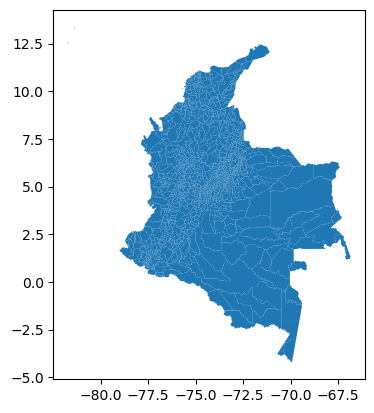

In [6]:
# Plot the geodataframe using Matplotlib
colboundary.plot()

In [7]:
# Select Putumayo Department, print the CRS, and call the data
putumayo = colboundary[colboundary["NOM_DEPART"].isin(["PUTUMAYO"])]
putumayo
print(putumayo.crs)

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]


<Axes: >

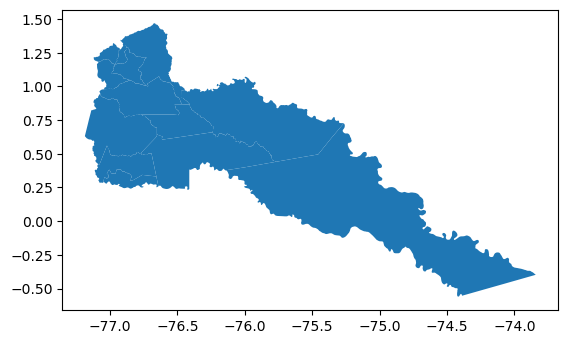

In [8]:
# Plot Putumayo using .plot()
putumayo.plot()

In [9]:
# Select Puerto Asís from Putumayo
ptoasis = colboundary[colboundary["NOM_MUNICI"].isin(["PUERTO ASÍS"])]
ptoasis

,ID_ESPACIA,AREA_OFICI,ENTIDAD_TE,NOM_DEPART,NOM_MUNICI,COD_DEPTO,geometry
1003,86568,2800.64,Cabecera Municipal,PUTUMAYO,PUERTO ASÍS,86,"POLYGON ((-76.14319 0.37627, -76.14494 0.37667..."


In [10]:
# NOTE: the following syntax also works to select/subset data
ptoasis = putumayo[putumayo["NOM_MUNICI"] == "PUERTO ASÍS"]
ptoasis

,ID_ESPACIA,AREA_OFICI,ENTIDAD_TE,NOM_DEPART,NOM_MUNICI,COD_DEPTO,geometry
1003,86568,2800.64,Cabecera Municipal,PUTUMAYO,PUERTO ASÍS,86,"POLYGON ((-76.14319 0.37627, -76.14494 0.37667..."


<Axes: >

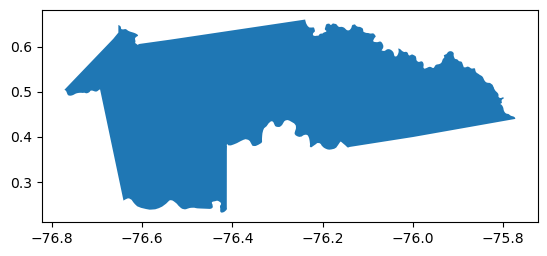

In [11]:
# Plot Puerto Asís
ptoasis.plot()

## Opening and clipping **raster** data

In [12]:
# Define url to 2002 raster data
raster_2002_url = ("https://data.cyverse.org/dav-anon/iplant/home/shared/"
                   "earthlab/geopark/landcover_colombian_amazon_2002.tif")

In [13]:
# Define url to 2016 raster data
raster_2016_url = ("https://data.cyverse.org/dav-anon/iplant/home/shared/"
                   "earthlab/geopark/landcover_colombian_amazon_2016.tif")

<Axes: >

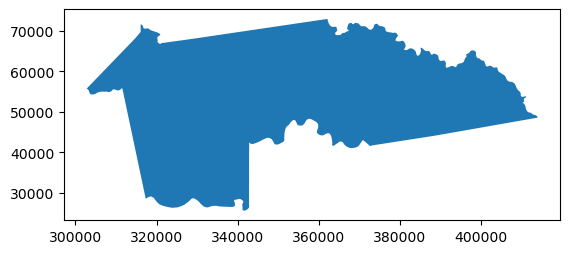

In [14]:
# Reproject Puerto Asís shp to same CRS as raster (EPSG:32618) and plot
ptoasis_32618 = ptoasis.to_crs("EPSG:32618")
ptoasis_32618.plot()

In [15]:
# Open and clip the 2002 raster data to the Puerto Asis boundary using rioxarray
rdclipped_2002 = rxr.open_rasterio(raster_2002_url, masked=True).squeeze().rio.clip(ptoasis_32618.geometry, from_disk=True)
rdclipped_2002

<xarray.DataArray (y: 1577, x: 3708)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 3.028e+05 3.028e+05 3.028e+05 ... 4.14e+05 4.14e+05
  * y            (y) float64 7.293e+04 7.29e+04 ... 2.568e+04 2.565e+04
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        7
    STATISTICS_MEAN:           1.3176634733616
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         0.99581730881901
    STATISTICS_VALID_PERCENT:  34.03
    scale_factor:              1.0
    add_offset:                0.0

In [28]:
# Check CRS of the raster data
rdclipped_2002.rio.crs

CRS.from_epsg(32618)

In [29]:
# Open and clip the 2016 raster data to the Puerto Asis boundary using rioxarray
rdclipped_2016 = rxr.open_rasterio(raster_2016_url, masked=True).squeeze().rio.clip(ptoasis_32618.geometry, from_disk=True)
rdclipped_2016

<xarray.DataArray (y: 1577, x: 3708)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 3.028e+05 3.028e+05 3.028e+05 ... 4.14e+05 4.14e+05
  * y            (y) float64 7.293e+04 7.29e+04 ... 2.568e+04 2.565e+04
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        7
    STATISTICS_MEAN:           1.3297671847732
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         1.0287005111847
    STATISTICS_VALID_PERCENT:  34.03
    scale_factor:              1.0
    add_offset:                0.0

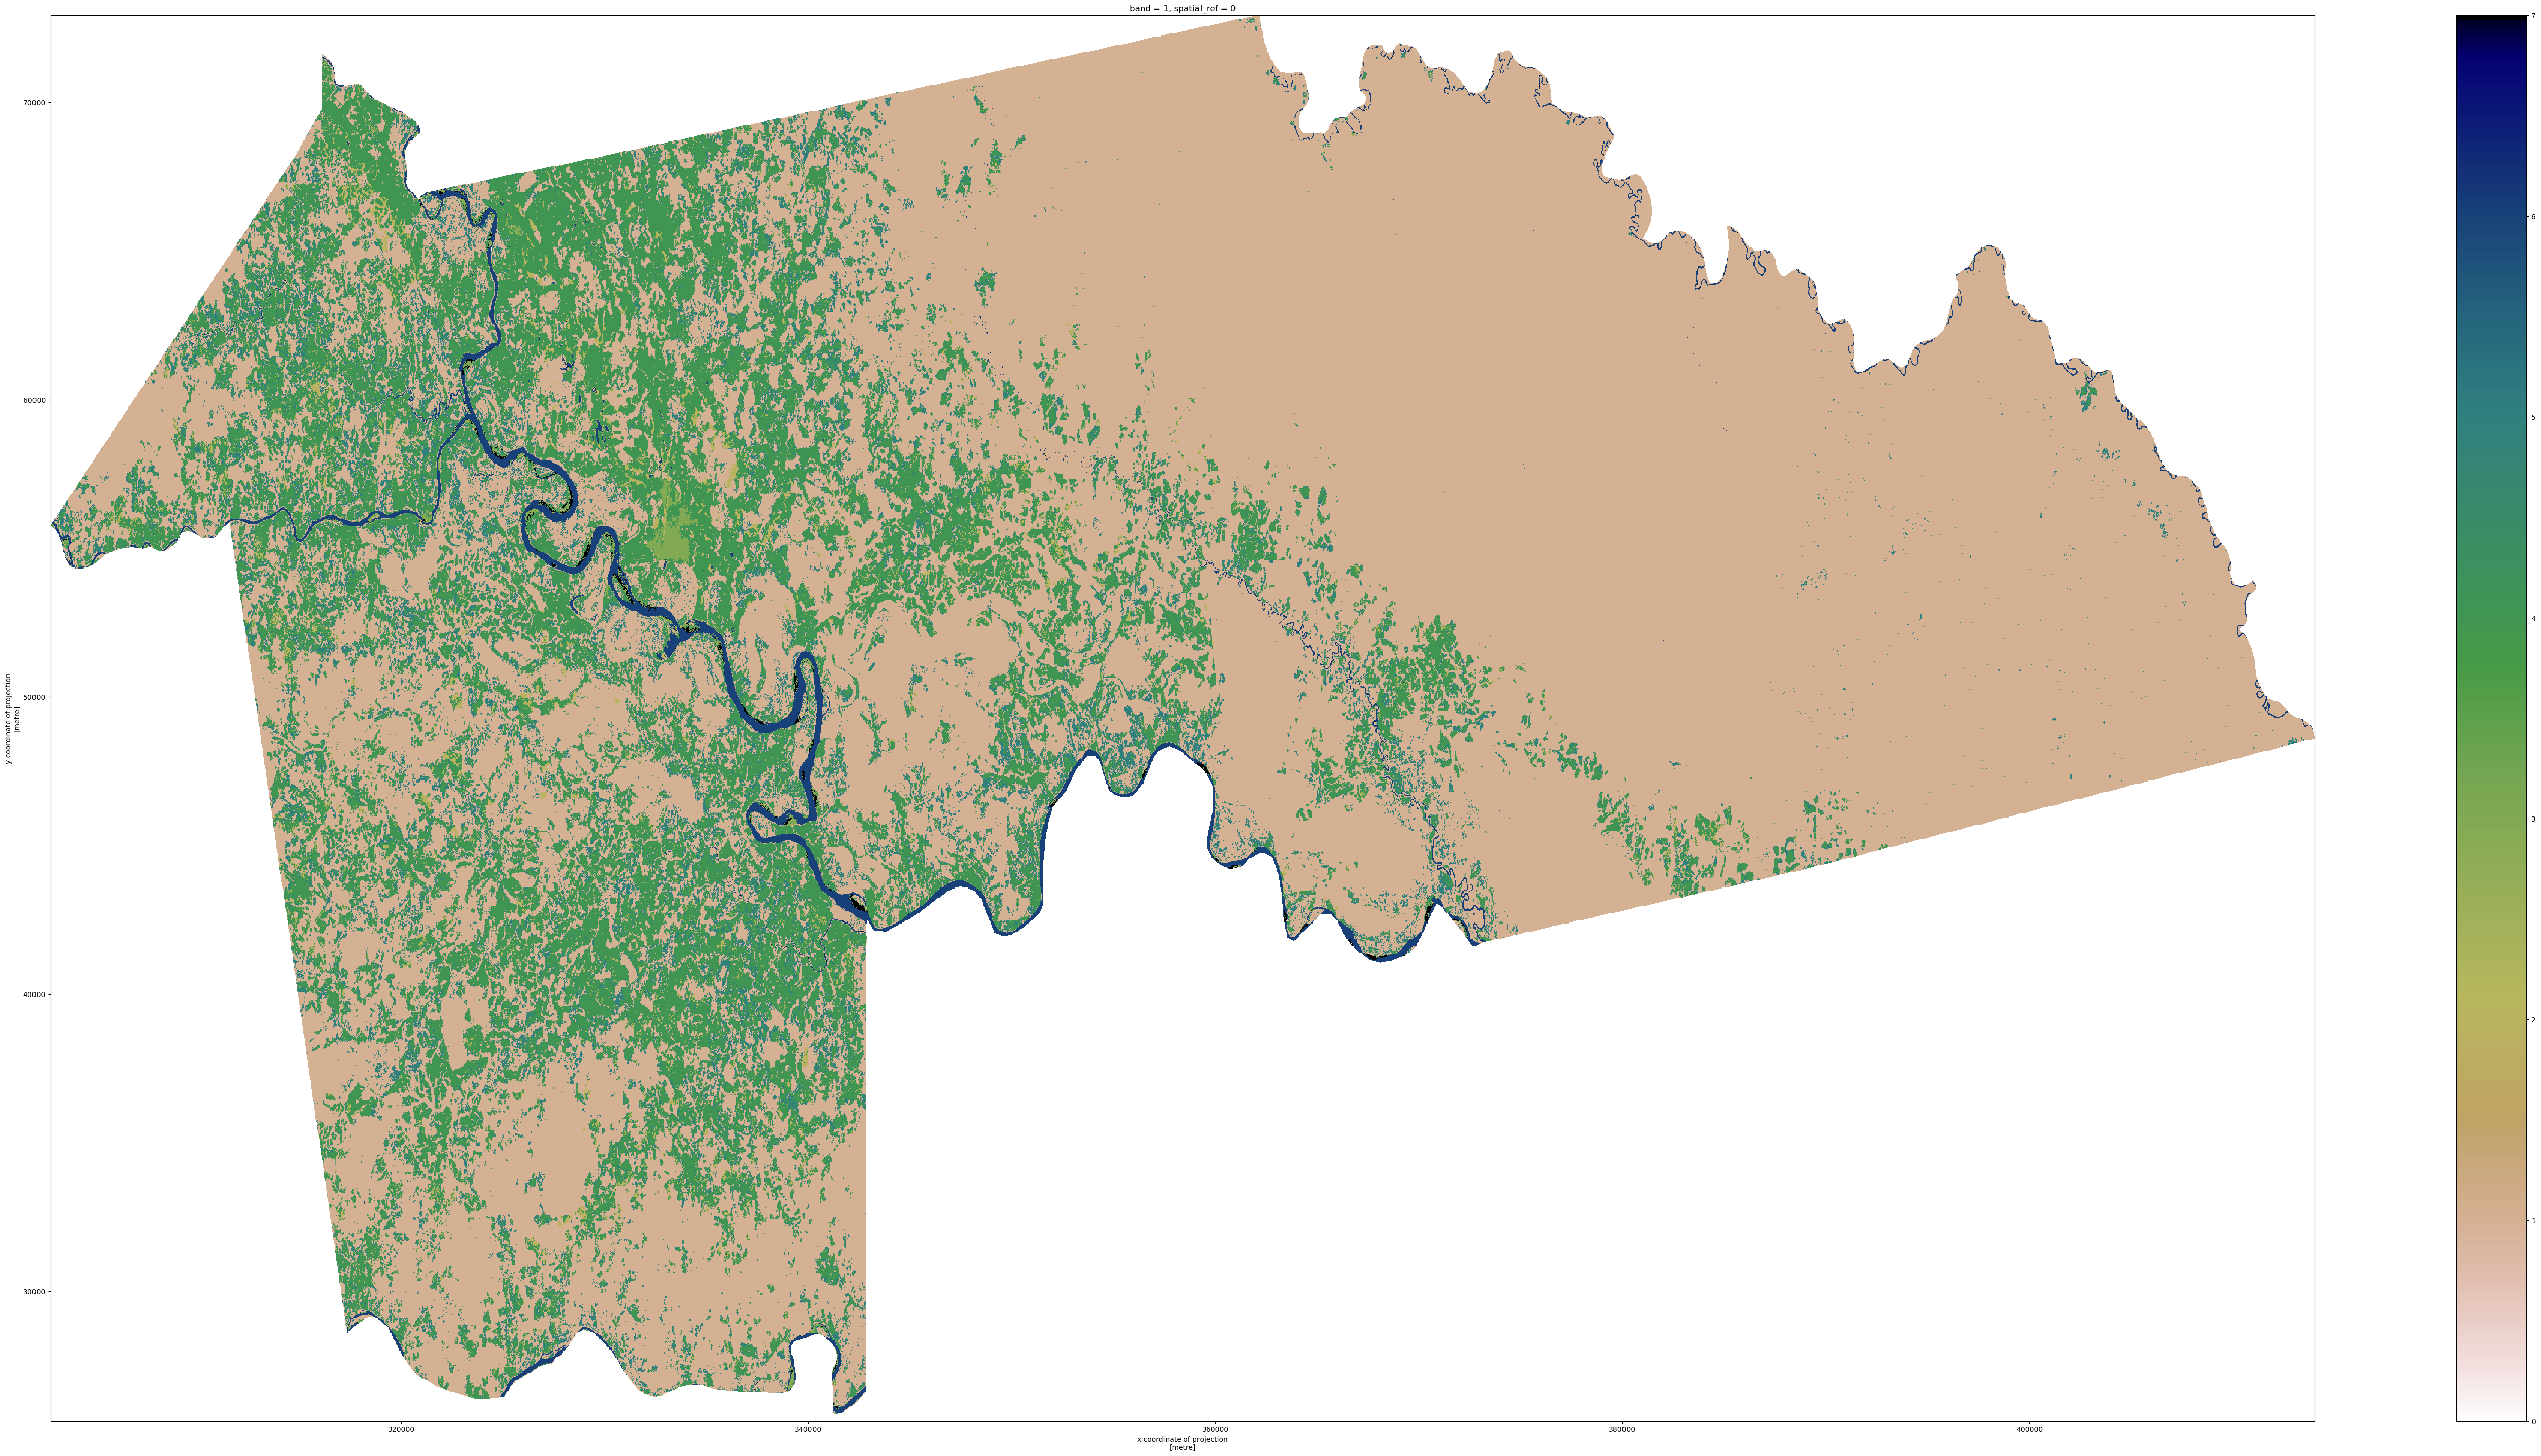

In [31]:
# Plot the raster clipped to Puerto Asís (2002)
fig, ax = plt.subplots(figsize=(72,36))
rdclipped_2002.plot(ax=ax,
                    add_colorbar=True,
                    cmap="gist_earth_r")
plt.show()

## Creating a categorical color map

In [19]:
# Customizing the cmap (ChatGPT)
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# NOTE: Colors and landuses from the CMS User Guide:
# https://daac.ornl.gov/CMS/guides/Landcover_Colombian_Amazon.html

cms_colors = ['black',
              'forestgreen',
              'orange',
              'purple',
              'darkgoldenrod',
              'limegreen',
              'tab:blue',
              'yellow']

cms_cmap = ListedColormap(cms_colors)

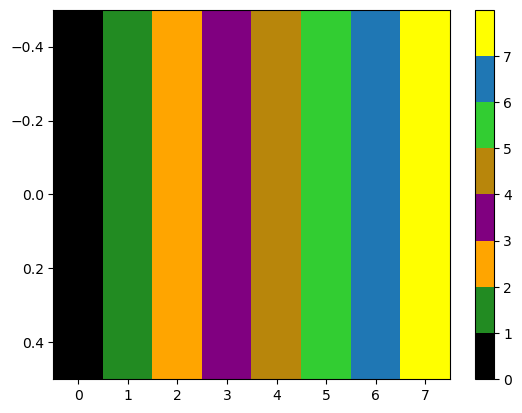

In [20]:
# Create a dummy array to map colors to
dummy_data = np.arange(8).reshape(1, -1)

# Plot the colorbar
plt.imshow(dummy_data, cmap=cms_cmap, aspect='auto', vmin=0, vmax=8)
plt.colorbar(ticks=np.arange(8))
plt.show()

In [21]:
# Create custom labels ()

# Define labels
landuse_labels = ["Unclassified",
                  "Forest",
                  "Natural Grassland",
                  "Urban",
                  "Pasture",
                  "Secondary Forest",
                  "Water",
                  "Highly Reflective Surface"]

# Define bins
class_bins = [0,1,2,3,4,5,6,7,10]

# Define norm
norm = BoundaryNorm(class_bins,
                    len(cms_colors))

In [22]:
# Creating the legend elements

from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color='black', lw=18, label='Unclassified',),
                   Line2D([0], [0], color='forestgreen', lw=18, label='Forest'),
                   Line2D([0], [0], color='orange', lw=18, label='Natural Grassland'),
                   Line2D([0], [0], color='purple', lw=18, label='Urban'),
                   Line2D([0], [0], color='darkgoldenrod', lw=18, label='Pasture'),
                   Line2D([0], [0], color='limegreen', lw=18, label='Secondary Forest'),
                   Line2D([0], [0], color='tab:blue', lw=18, label='Water'),
                   Line2D([0], [0], color='yellow', lw=18, label='Highly Reflective Surface')]


## Plotting clipped **raster** data

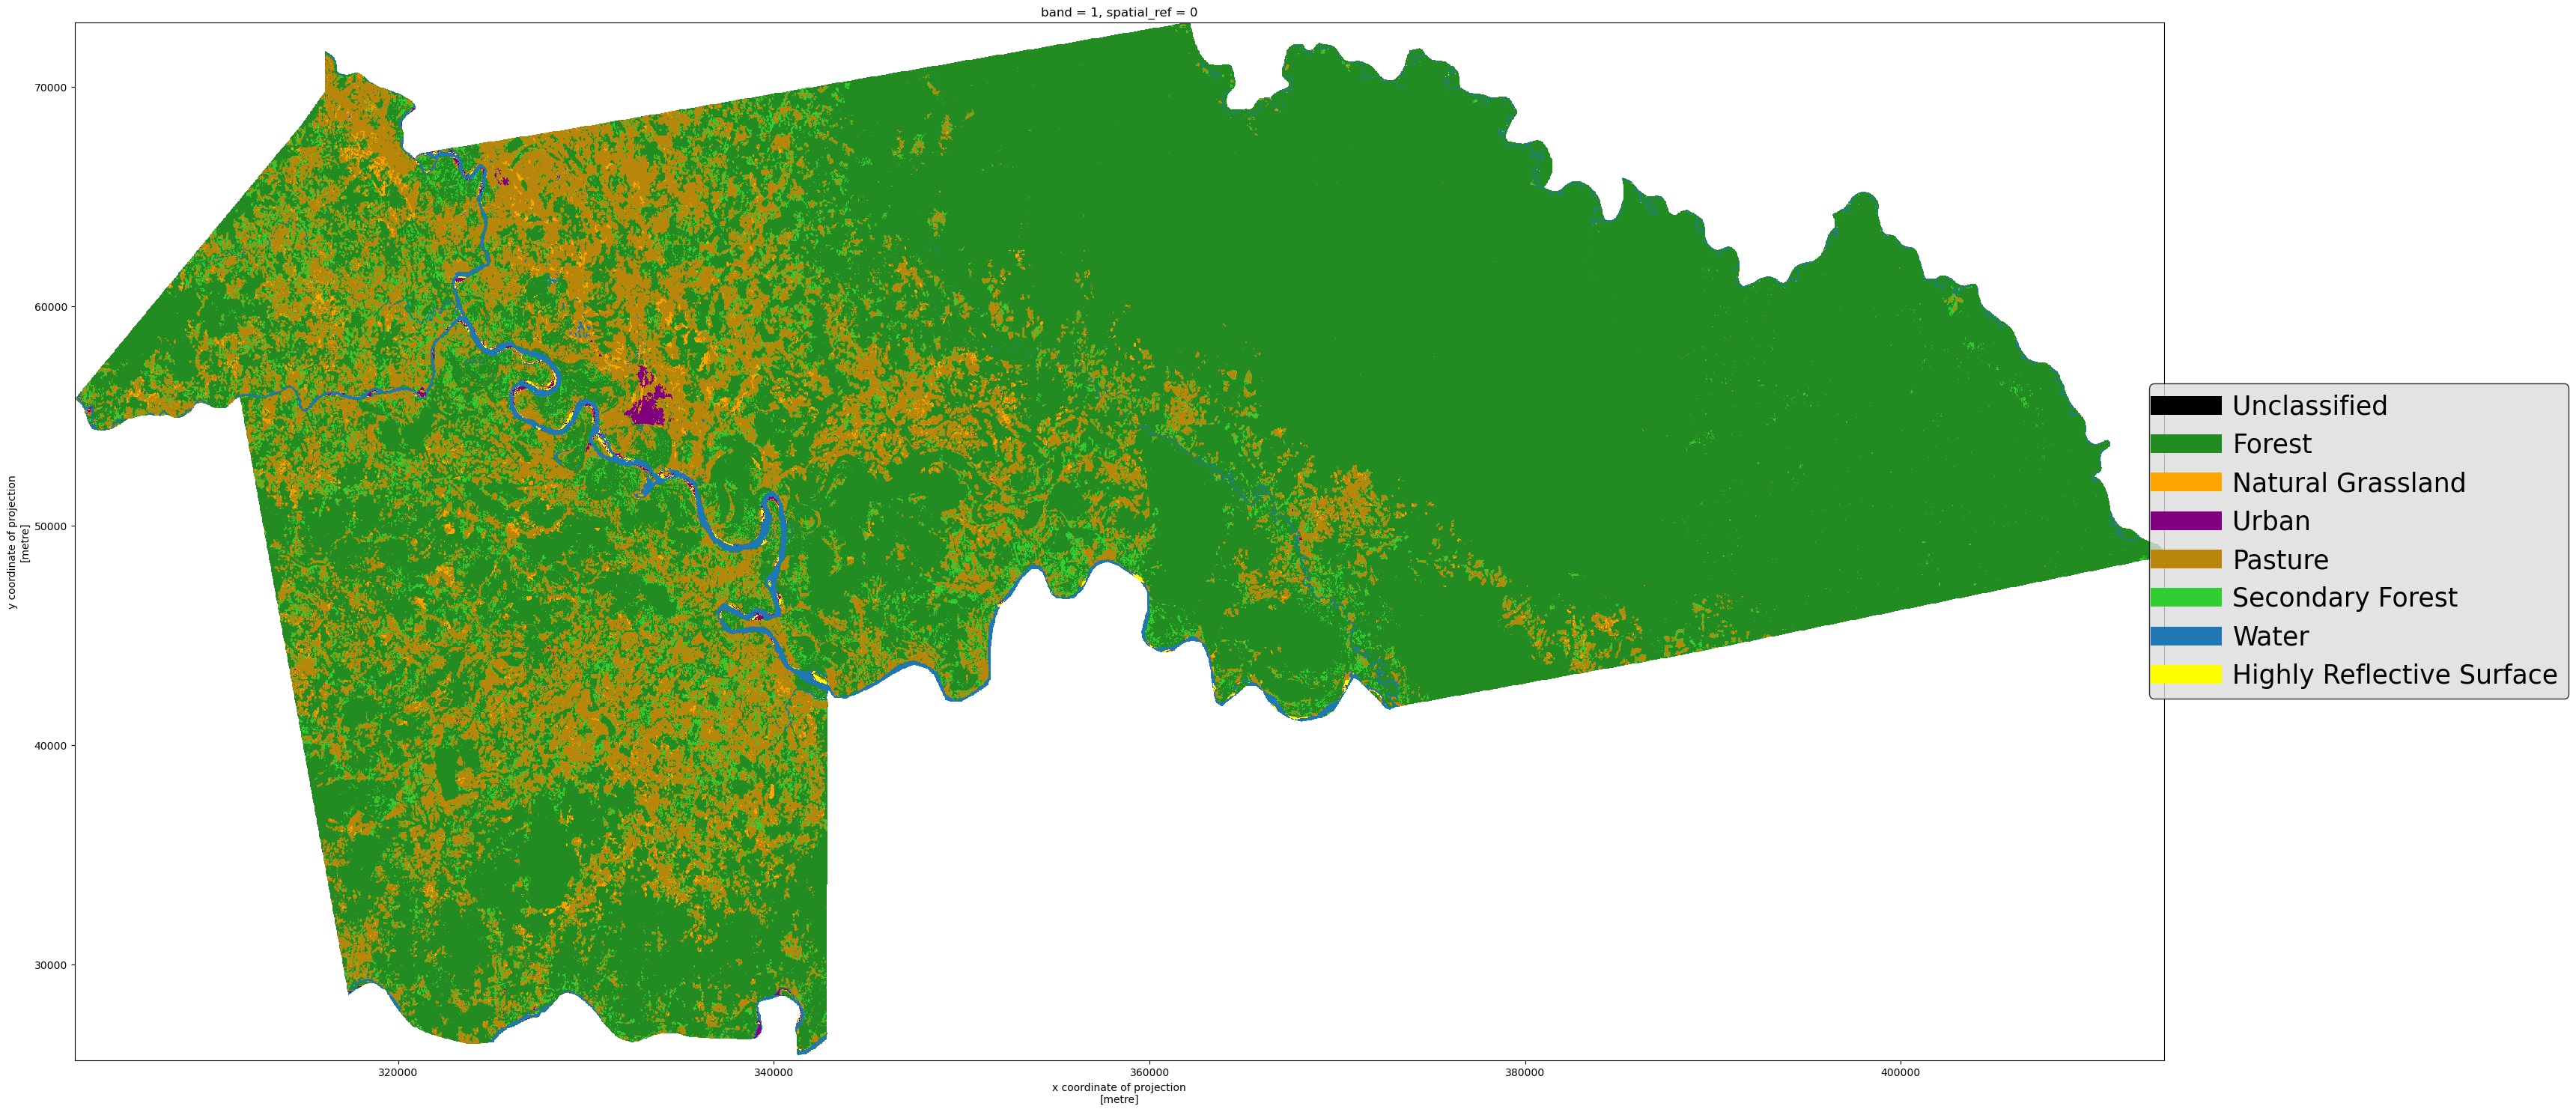

In [34]:
# Plot the raster clipped to Puerto Asís (2002)
fig, ax = plt.subplots(figsize=(36,18))
rdclipped_2002.where(rdclipped_2002!=rdclipped_2002.rio.nodata).plot(ax=ax,
                                                                     add_colorbar=False,
                                                                     cmap=cms_cmap,
                                                                     norm=norm)
ax.legend(handles=legend_elements,
          loc="right",
          fontsize="25",
          facecolor="gainsboro",
          edgecolor="black",
          bbox_to_anchor=(1.2,0.5))

plt.show()


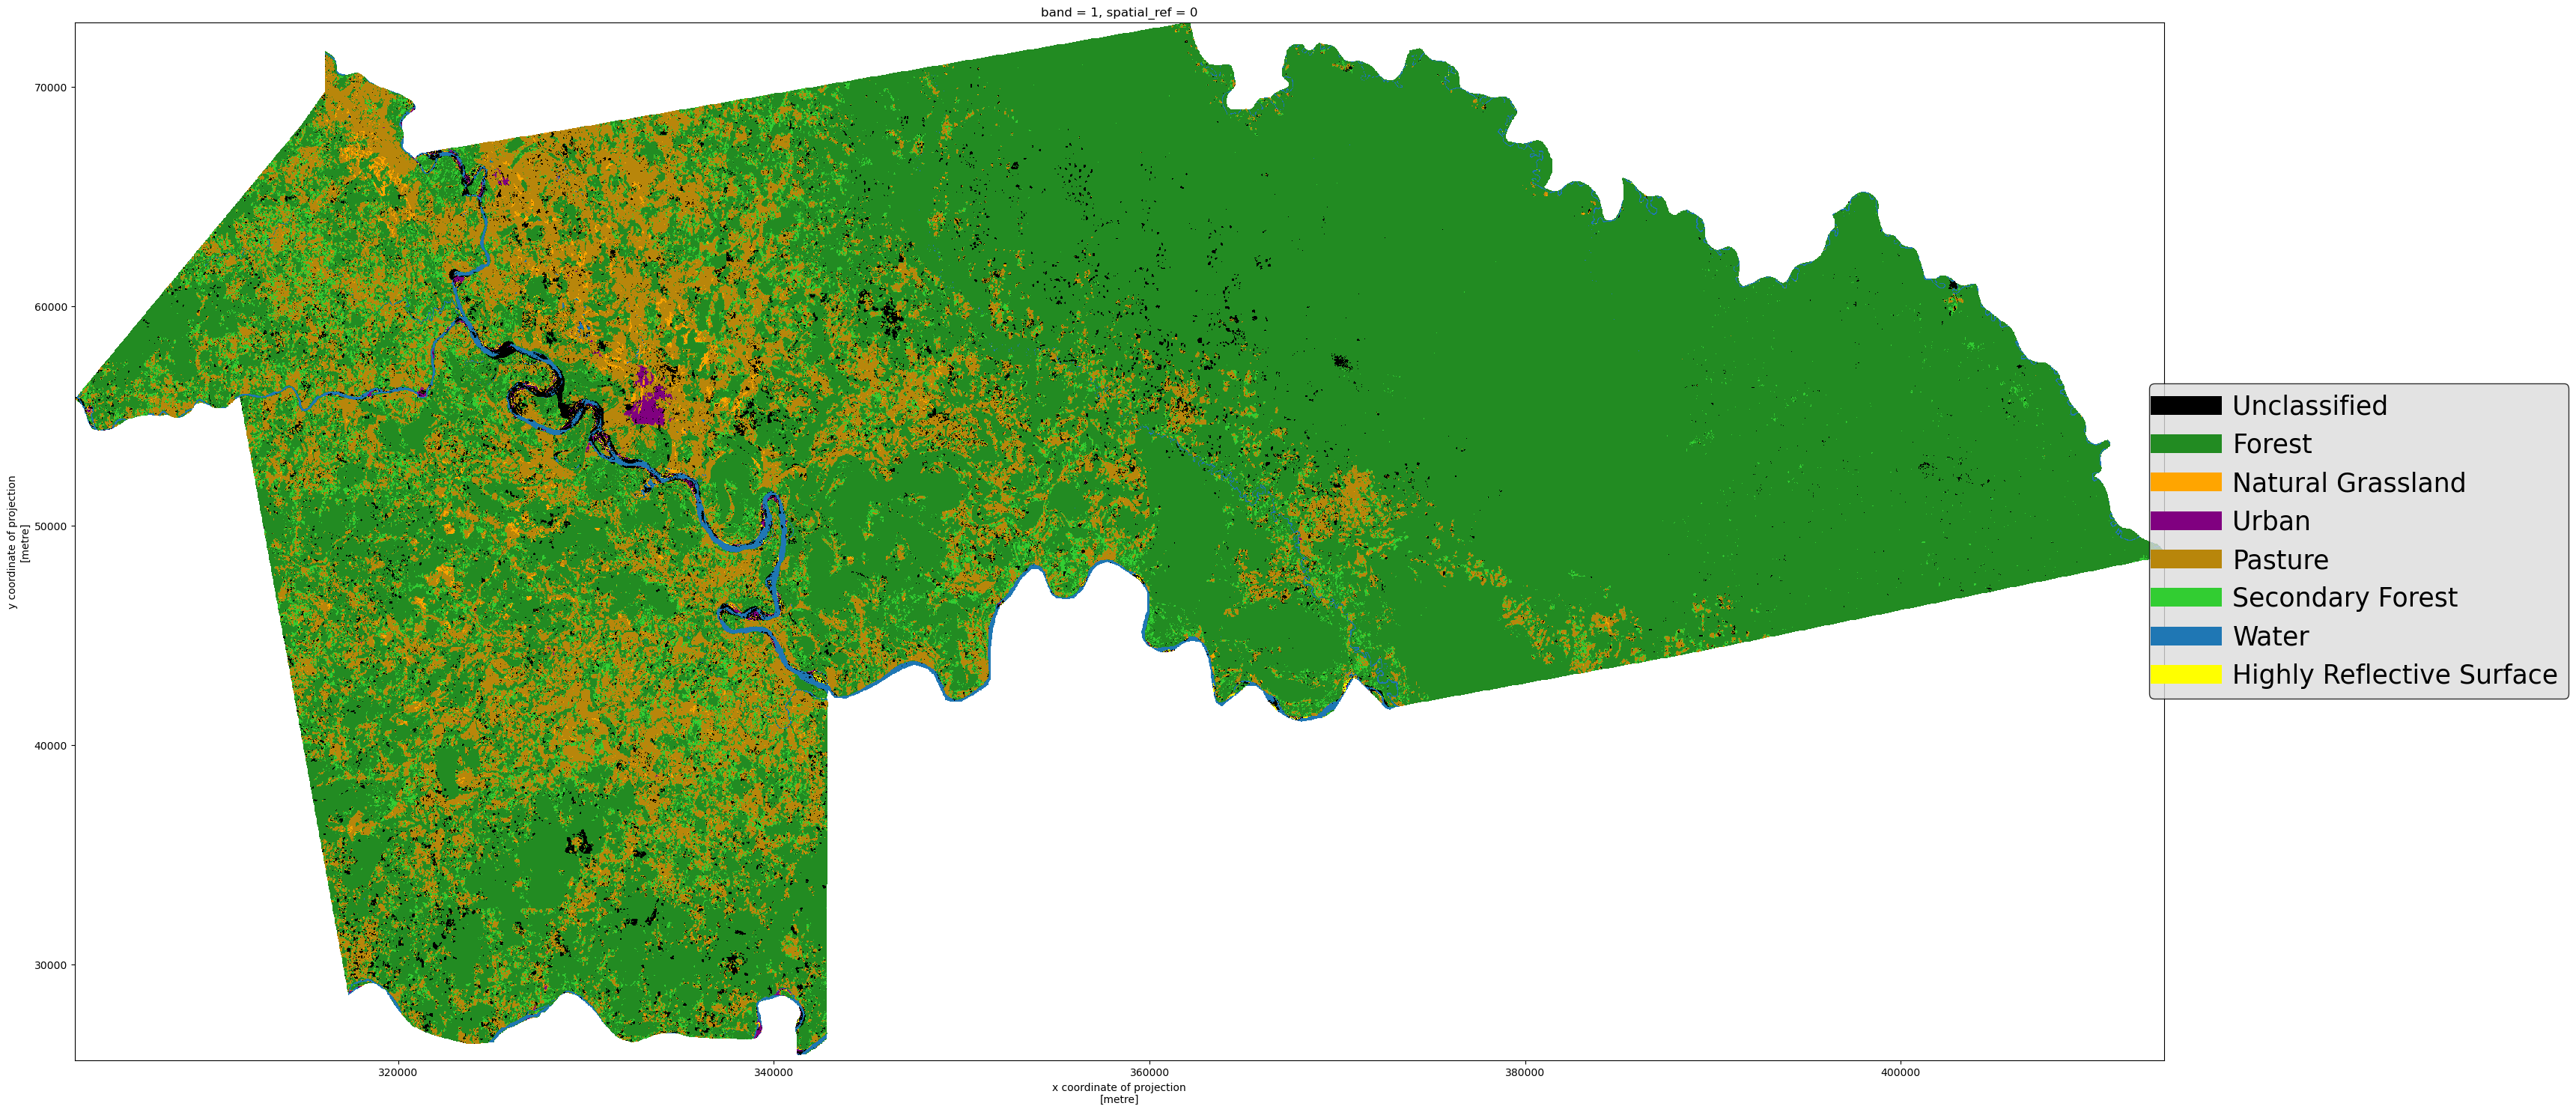

In [35]:
# Plot the raster clipped to Puerto Asís (2016)
fig, ax = plt.subplots(figsize=(36,18))
rdclipped_2016.where(rdclipped_2016!=rdclipped_2016.rio.nodata).plot(ax=ax,
                                                                     add_colorbar=False,
                                                                     cmap=cms_cmap,
                                                                     norm=norm)
ax.legend(handles=legend_elements,
          loc="right",
          fontsize="25",
          facecolor="gainsboro",
          edgecolor="black",
          bbox_to_anchor=(1.2,0.5))

plt.show()

(<Figure size 1200x1200 with 1 Axes>, <Axes: title={'center': 'Landuse 2002'}>)

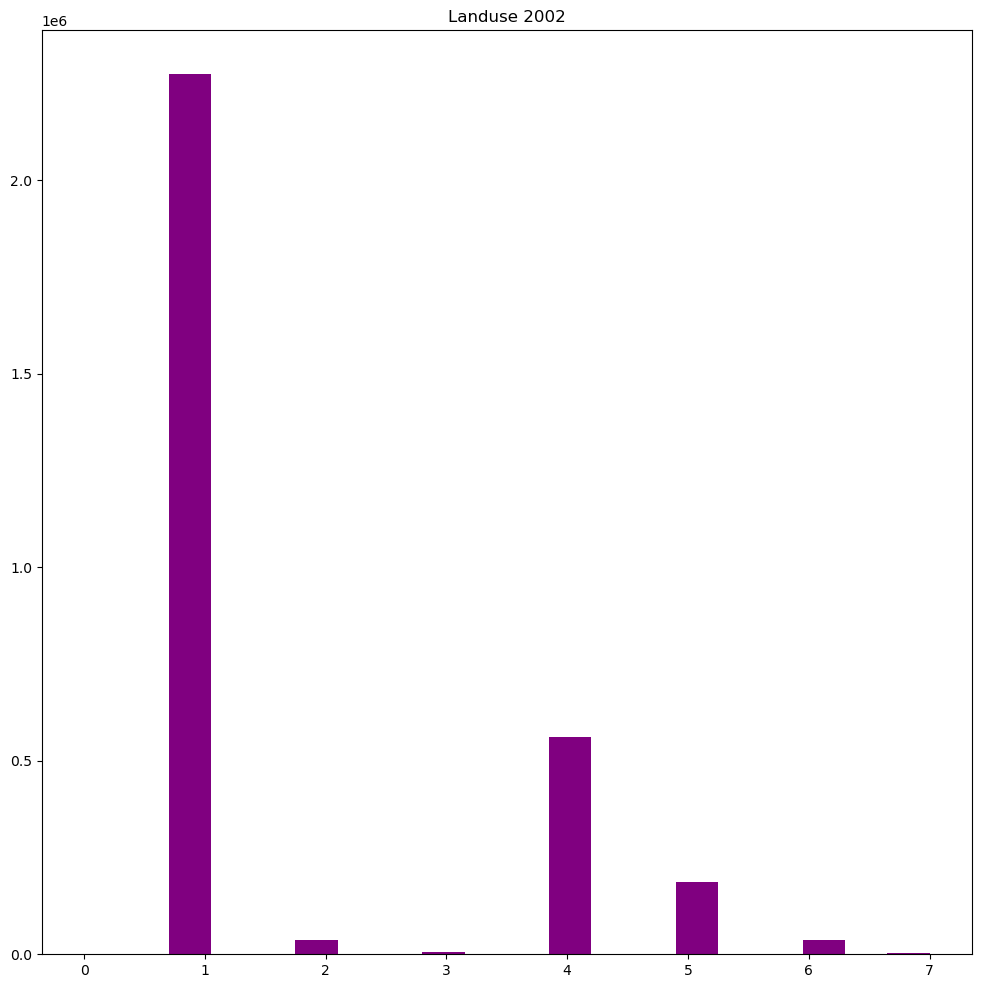

In [36]:
# Creating histograms of 2002 pixel counts
ep.hist(rdclipped_2002.values, title="Landuse 2002")

(<Figure size 1200x1200 with 1 Axes>, <Axes: title={'center': 'Landuse 2016'}>)

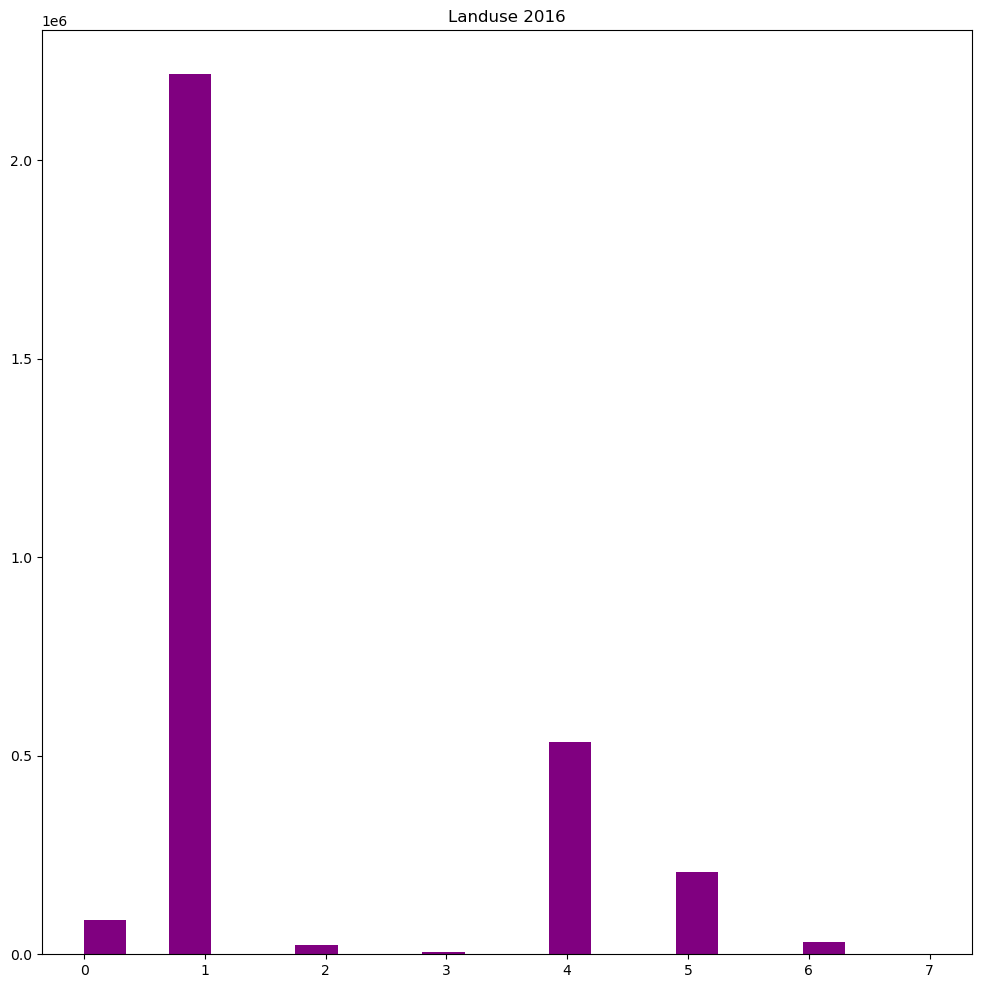

In [37]:
# Creating histograms of 2016 pixel counts
ep.hist(rdclipped_2016.values, title="Landuse 2016")

(array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 2.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0., 10.,  0., ...,  0.,  0.,  0.],
        [ 0.,  8.,  0., ...,  0.,  0.,  0.],
        [ 0.,  3.,  0., ...,  0.,  0.,  0.]]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <a list of 3708 BarContainer objects>)

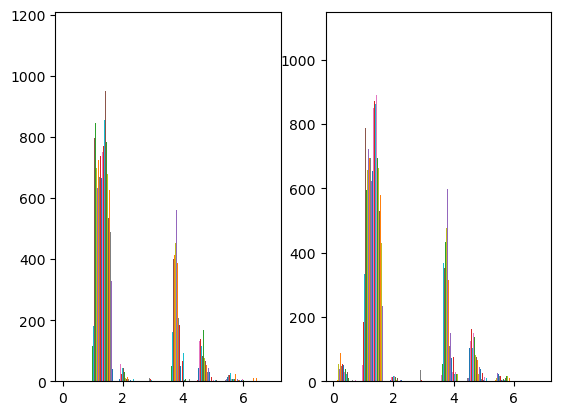

In [39]:
#Plot histograms side-by-side
fig,(ax1,ax2) = plt.subplots(1,2, sharex=True)
ax1.hist(rdclipped_2002.values, bins=8)
ax2.hist(rdclipped_2016.values, bins=8)